In [152]:
%load_ext autoreload
%autoreload 2

import polars as pl
from matchviz import get_tile_coords, load_points, ome_ngff_to_coords, plot_points, scale_points, translate_points, read_bigstitcher_xml, tokenize
import fsspec
bs_url = "s3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38_alignment_2024-05-07_18-15-25/"
spimdata = read_bigstitcher_xml(bs_url)
tile_coords= get_tile_coords(spimdata)
url = "s3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38_alignment_2024-05-07_18-15-25/interestpoints.n5/tpId_0_viewSetupId_0/beads/"
image_url = 's3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38/SPIM.ome.zarr/tile_x_0000_y_0000_z_0000_ch_488.zarr'

points, matches = load_points(url)
coords = ome_ngff_to_coords(image_url)
points_tx = scale_points(translate_points(points, coords), coords)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
tile_positions = {k: (v['x']['translation'], v['y']['translation']) for k,v in tile_coords.items()}
tile_x, tile_y = zip(*tuple(t for t in tile_positions.values()))
tile_coords_normed = tuple(zip(tokenize(tile_x), tokenize(tile_y)))

In [175]:
tile_coords_normed

((4, 0),
 (4, 1),
 (4, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (0, 0),
 (0, 1),
 (0, 2))

In [168]:

import numpy.typing as npt
import numpy as np


In [ ]:
tokenize()

In [142]:
import os
points_url_base = "s3://aind-open-data/exaSPIM_708373_2024-04-02_19-49-38_alignment_2024-05-07_18-15-25/interestpoints.n5/"
fs, path = fsspec.url_to_fs(points_url_base)
all_beads= ('s3://' + v for v in fs.glob(os.path.join(path, '*/beads/')))

matches_dict = {}

for bead_path in all_beads:
    try:
        _, matches = load_points(bead_path)
        matches_dict[bead_path] = matches
    except BaseException as e:
        print(e)
    


In [146]:
def summarize_match(match: pl.DataFrame) -> pl.DataFrame:
    return match.group_by('id_self', 'id_other').agg(pl.col('point_self').count()).rename({'point_self': 'num_matches'})

In [147]:
match_vals = tuple(matches_dict.values())
summarized_matches = tuple(map(summarize_match, match_vals))

In [149]:
pl.concat(summarized_matches).sort('id_self')

id_self,id_other,num_matches
i64,u64,u32
0,1,4437
0,3,493
1,0,4437
1,2,21093
1,3,626
2,4,526
2,1,21093
2,5,128
3,7,65


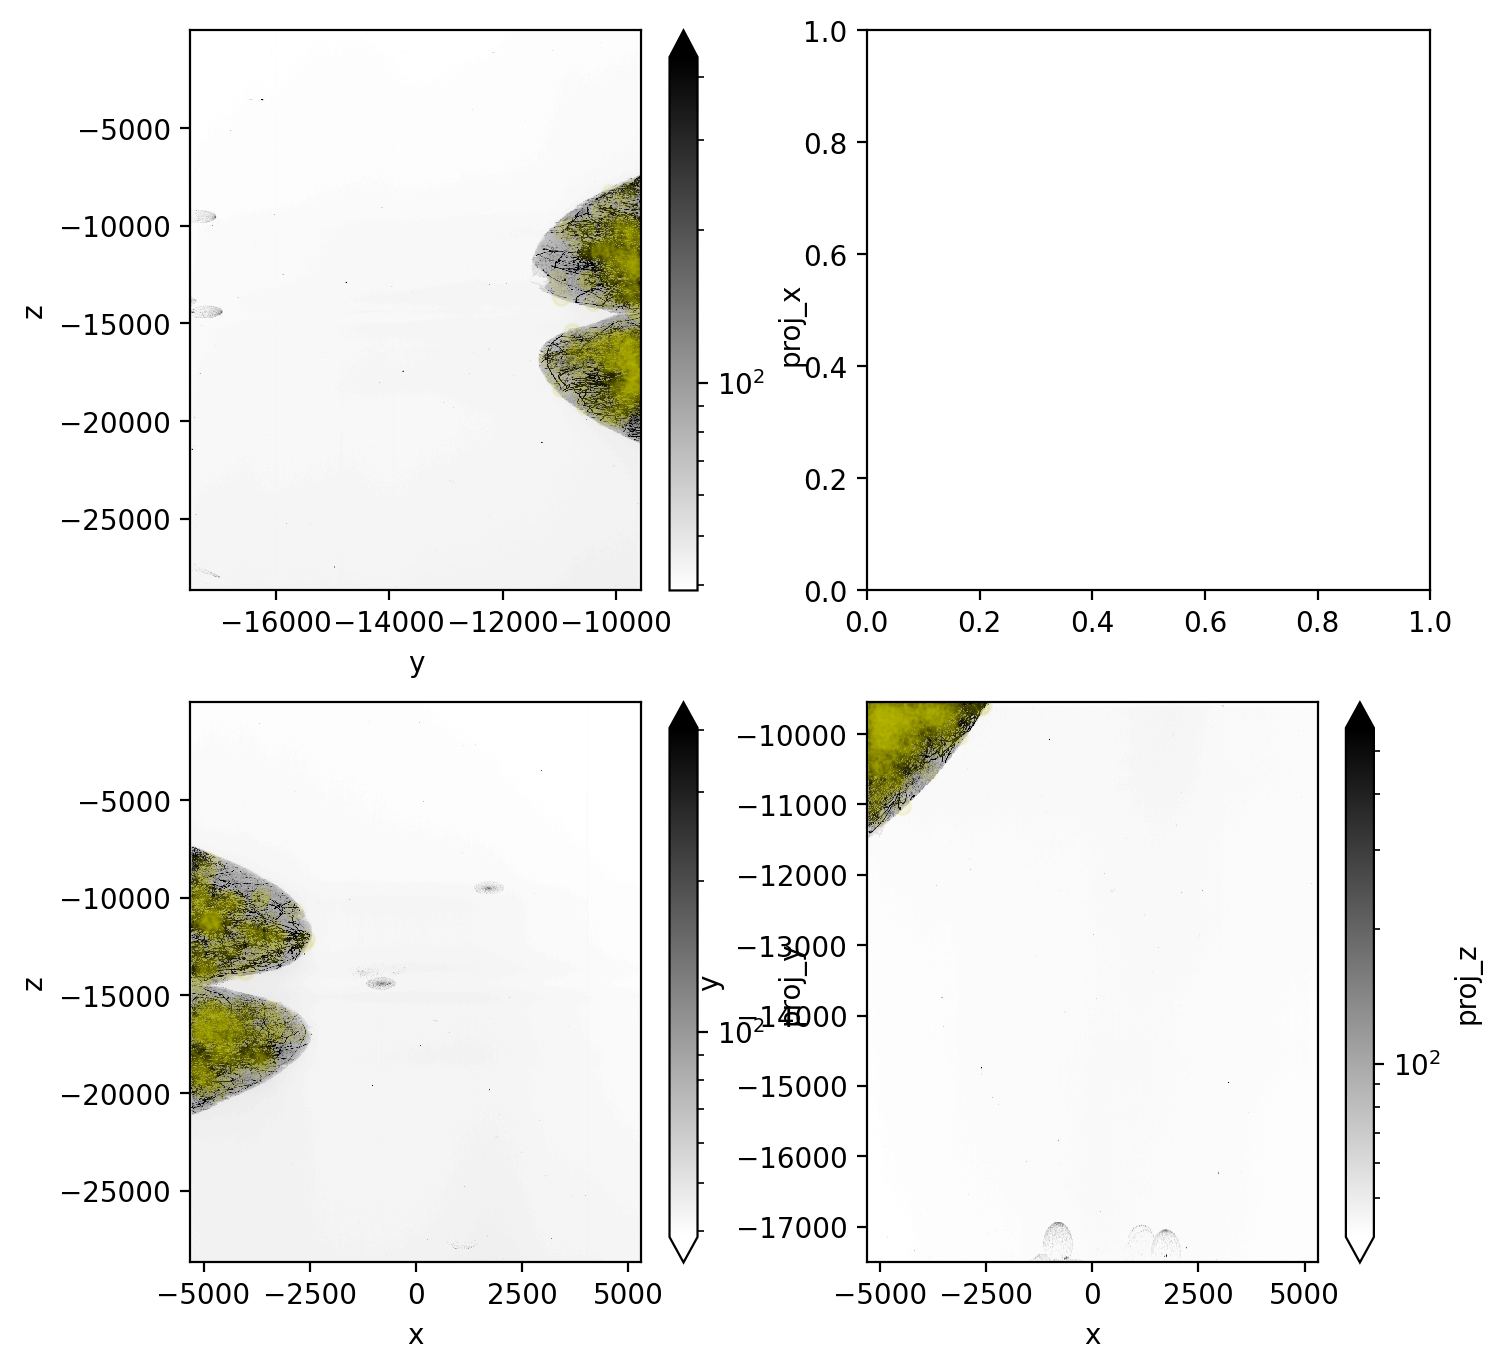

In [61]:
plot_points(points_tx[::100], image_url)

[img](/scratch/foo.svg)